## Sentiment Analysis
This notebook performs a sentiment analysis of the 'Cereals' subchapter of 'Annual Review and Outlook for Agriculture, Food and the Marine 2022'. A score is returned and bar charts are plotted. The resulting score is tested against a summary of the chapter as written by OpenAI's GPT3.

In [1]:
import io
import re
import nltk
import textblob
import PyPDF2
import statistics
import pandas as pd


The function getSentimentScores() splits PDF into pages and analyses the text. The pages for the subchapter are identified by the user and given as inputs for the function. The selected pages are further broken down and Textblob is used to return a score for each sentence of the chapter. Finally, the mean score is returned, as well as a dataframe that includes each sentence and it's score.

In [2]:
def getSentimentScores(pdf_path, startPage, stopPage):
  # Open the PDF file and extract the text
  with open(pdf_path, 'rb') as f:
    pdf_reader = PyPDF2.PdfReader(f)
    text = ""
    #for page in range(len(pdf_reader.pages)):
    for page in range(startPage,stopPage):
      text += pdf_reader.pages[page].extract_text()
  
  # Split the text into sentences
  sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
  sentences = sent_detector.tokenize(text)
  
  # Remove stopwords from the sentences
  stopwords = nltk.corpus.stopwords.words('english')
  # stopwords = ['the','of','a','or','at','in','for']

  filtered_sentences = []
  for sentence in sentences:
    words = nltk.word_tokenize(sentence)
    filtered_words = [word for word in words if word.lower() not in stopwords]
    filtered_sentence = " ".join(filtered_words)
    filtered_sentences.append(filtered_sentence)
  
  # Get the sentiment scores for each sentence
  scores = []
  scoresDF = pd.DataFrame()
  for sentence in filtered_sentences:
    sentiment = textblob.TextBlob(sentence).sentiment.polarity
    scores.append(sentiment)
  scoresDF['Sentences'] = filtered_sentences
  scoresDF['Scores'] = scores
    

  return statistics.mean(scores),scoresDF

meanScores, df = getSentimentScores('../CA2/Annual Review and Outlook for Agriculture, Food and the Marine 2022.pdf',113,121)

A bar chart is plotted showing scores for the subchapter. Scores that are within the range of -0.05 and 0.05 are considered neutral and are dropped. Results show a slight bias to positive, both in the value of the most frequent score and also the magnitude. However, this plot could be subjective in terms of the chapters overall sentiment due to the prevelance of lower sentiment scores.

In [3]:
# Average sentiment score
print(meanScores)

0.04033440191962919


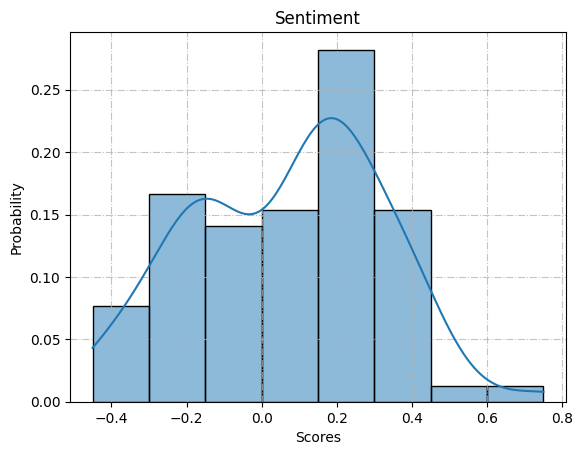

In [4]:
dfdrop = df[(df['Scores'] < -0.05) | (df['Scores'] > 0.05) ]
import matplotlib.pyplot as plt
import seaborn as sns

import statistics
fig = plt.figure(1)
ax = sns.histplot(dfdrop['Scores'], kde=True, stat='probability');
ax.set_title('Sentiment')
ax.grid(True, ls='-.', alpha=0.75)

Due to the subjectivity of the above plot it is decided to simply characterise the sentiment as negative when the score is less than -0.05 and positive when greater than 0.05. Values in between are neutral. The plots show that there is indeed a slight positive bias. 

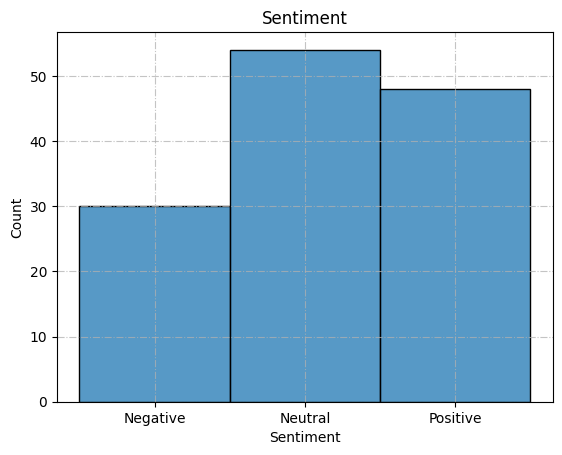

In [5]:
df['Sentiment'] = ['Positive' if x > 0.05 else 'Negative' if x < -0.05 else 'Neutral' for x in df['Scores'] ]
df['Sentiment'] = pd.Categorical(df['Sentiment'], ['Negative','Neutral','Positive'])


fig = plt.figure(2)
ax = sns.histplot(df['Sentiment'], stat='count');
ax.set_title('Sentiment')
ax.grid(True, ls='-.', alpha=0.75)

## Chapter Summarisation using OpenAI's GPT3
In order to test the results above, OpenAI's GPT3 was utilised to summarise the chapter. The user can then quickly read the summary and assess the sentiment of the result.
A function is written called summariseSection() that requires the user's OpenAI API key, the path to the PDF, the section start page, and the section end page.

In [9]:
import openai
import PyPDF2
import numpy as np

def summariseSection(key, pdf_path, startPage, stopPage):
    # Set the OpenAI API key
   
    openai.api_key = key
    
    # Open the PDF file
    with open(pdf_path, "rb") as file:
        # Create a PDF object
        pdf = PyPDF2.PdfReader(file)

        # Get the number of pages
        num_pages = len(pdf.pages)

        # Initialize a dictionary to store the pages
        pages = []

        # Iterate through each page
        for i in range(num_pages):
            # Extract the page
            page = pdf.pages[i]
            # Store the page in the dictionary
            pages.append(page.extract_text())

    summaryAll = []
    for chunkNum in pages[113:121]:

        # Use the TLDR model to summarize the text
        model_engine = "text-davinci-002"
        prompt = (f"{chunkNum}\n\ntl;dr:")

        completions = openai.Completion.create(
            engine=model_engine,
            prompt=prompt,
            max_tokens=1024,
            n=1,
            stop=None,
            temperature=0.5,
        )

        # Print the summary
        summary = completions.choices[0].text
        #print(summary)
        summaryAll.append(summary)
    return summaryAll

In [ ]:
path = 'Annual Review and Outlook for Agriculture, Food and the Marine 2022.pdf'
key = input('Enter your OpenAI API key')
summary = summariseSection(key, path, 113, 121)

In [12]:
for i in range(len(summary)):
    print(summary[i])



Cereal production in Ireland is expected to increase in 2021, due to higher yields from winter crops and lower area planted in spring crops. Maize plantings are also expected to increase.


The area of spring and winter wheat, barley, and oats in 2019-2021 is expected to remain relatively stable, with some slight decreases in spring wheat and oats area. The area of non-cereal crops is expected to decrease slightly in 2021, driven by a decrease in spring beans. Maize and beet area are expected to remain stagnant, while oilseed rape area is expected to increase slightly. Straw production is expected to be strong in 2021, with prices slightly higher than in 2020.


Cereal production in the EU is forecast to increase by 4.3% in 2021/22, with output expected to be higher in France and Romania. However, some EU countries are expected to see a decrease in production due to drought and excessive wet & cold conditions.


The tillage sector in the EU is expected to see increases in both produc